# Линейный Энкодер-Декодер

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
plt.style.use('seaborn')

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from functions import *
from functions import good_cols, SignalDataset
%matplotlib inline

In [3]:
all_df = get_df()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.01s/it]


### Выбираем длину

In [7]:
TARGET_LEN = 10000
activities = sep_by_len(all_df, TARGET_LEN)
activities.shape

(83, 32)

In [16]:
CUT_LEN = 500
cut_df = cut_act(activities, CUT_LEN, count=10, random_start=True)
cut_df.sample()

100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 67.30it/s]


,activityID,heart rate,temperature hand,3Da_x scale_16 hand,3Da_y scale_16 hand,3Da_z scale_16 hand,3Dg_x hand,3Dg_y hand,3Dg_z hand,3Dm_x hand,...,temperature ankle,3Da_x scale_16 ankle,3Da_y scale_16 ankle,3Da_z scale_16 ankle,3Dg_x ankle,3Dg_y ankle,3Dg_z ankle,3Dm_x ankle,3Dm_y ankle,3Dm_z ankle
315,1,"[77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77....","[32.5625, 32.5625, 32.5625, 32.5625, 32.5625, ...","[0.31857, 0.298701, 0.323119, 0.110102, 0.0501...","[-1.86642, -1.97525, -1.9789, -1.98348, -2.102...","[10.7122, 11.2511, 10.8666, 10.1706, 9.55432, ...","[-0.023271, -0.192594, -0.299251, -0.435078, -...","[0.047595, 0.0970895, 0.0955403, 0.108558, 0.1...","[0.0298807, 0.0225823, 0.0345088, 0.0774418, 0...","[39.39, 39.7658, 39.7474, 39.8733, 39.7429, 40...",...,"[33.125, 33.125, 33.125, 33.125, 33.125, 33.12...","[2.022, 2.12968, 1.95226, 1.83138, 1.94385, 1....","[-9.65754, -9.69493, -9.73461, -9.69336, -9.65...","[-0.0512793, -0.204301, 0.141432, -0.168781, -...","[-0.0467202, -0.0243975, -0.0885604, -0.041138...","[-0.0333793, -0.00166175, -0.0106538, -0.02182...","[-0.0094598, -0.00831586, -0.000691673, 0.0237...","[-19.548, -20.5659, -19.8038, -19.8065, -20.19...","[19.325, 19.6358, 19.2082, 19.3371, 19.3555, 1...","[-12.0151, -11.1681, -12.2995, -12.2997, -12.5..."


### Получаем признаки

In [17]:
X = cut_df.iloc[:, 1:].values

Y = cut_df.iloc[:, 0] # целевая переменная
X.shape, Y.shape

((830, 31), (830,))

In [18]:
y_targ = y_encode(Y)
np.unique(y_targ)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

### Нормализация

In [42]:
X_norm = normalize_dif_len(X)
X_norm.shape

(-44.73216715473328, 85.04181339423285, -2.732036490188942e-15)

### Приводим к одной длине

In [33]:
X_eq = np.transpose(np.array(X_norm,dtype=np.float64), axes = [1,0,2])
X_eq.shape

(830, 500, 31)

In [34]:
X_flat = get_flatten(X_eq)
X_flat.shape

(830, 15500)

In [36]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = \
    train_test_split(torch.FloatTensor(X_flat), torch.LongTensor(y_targ), random_state=42, test_size = 0.2)
X_train_tensor.shape, y_train_tensor.shape, np.unique(y_train_tensor), np.unique(y_val_tensor)

(torch.Size([664, 15500]),
 torch.Size([664]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64))

In [37]:
BATCH_SIZE = 64

trainset = SignalDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = SignalDataset(X_val_tensor, y_val_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
len(trainset)

664

## Подготовка модели

In [38]:
torch.min(X_train_tensor), torch.max(X_train_tensor)

(tensor(-44.7322), tensor(85.0418))

In [75]:
activation = nn.LeakyReLU

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 1024),
            activation(),
            nn.Linear(1024, 128),
            activation(),
            nn.Linear(128, 64),
            activation(),
            nn.Linear(64, 4),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 64),
            activation(),
            nn.Linear(64, 128),
            activation(),
            nn.Linear(128, 1024),
            activation(),
            nn.Linear(1024, input_size),
            
        )
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

net = Autoencoder(X_train_tensor.shape[1])

## Обучение

In [76]:
NUM_EPOCHS = 20

loss_fn = torch.nn.MSELoss()
losses = []
val_losses = []

learning_rate = 3e-3
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
ebar = tqdm(range(NUM_EPOCHS))

for epoch_num in ebar:
    running_loss = 0.0
    iter_num = 0
#     pbar = tqdm(enumerate(trainloader), total = len(trainloader))
    pbar = enumerate(trainloader)
    for iter_num, (X_batch, y_batch) in pbar:
        iter_num +=1
        
        recon = net(X_batch)
        
        loss = loss_fn(recon, X_batch)
        running_loss += loss.item()
                     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    line = '[{}/{}] current loss: {}'.format(epoch_num+1, NUM_EPOCHS, running_loss/len(trainset))
    ebar.set_description(line)
    
    losses.append(running_loss/len(trainset))
        
    with torch.no_grad():
        recon = net(X_val_tensor)
        score = loss_fn(recon, X_val_tensor)
#         line = '[{}/{}] current valid score: {}'.format(epoch_num+1, NUM_EPOCHS, f1_score(y_val_tensor, y, average='macro'))
#         print(line)
        val_losses.append(score)

[20/20] current loss: 0.010047864303531417: 100%|██████████████████████████████████████| 20/20 [00:49<00:00,  2.49s/it]


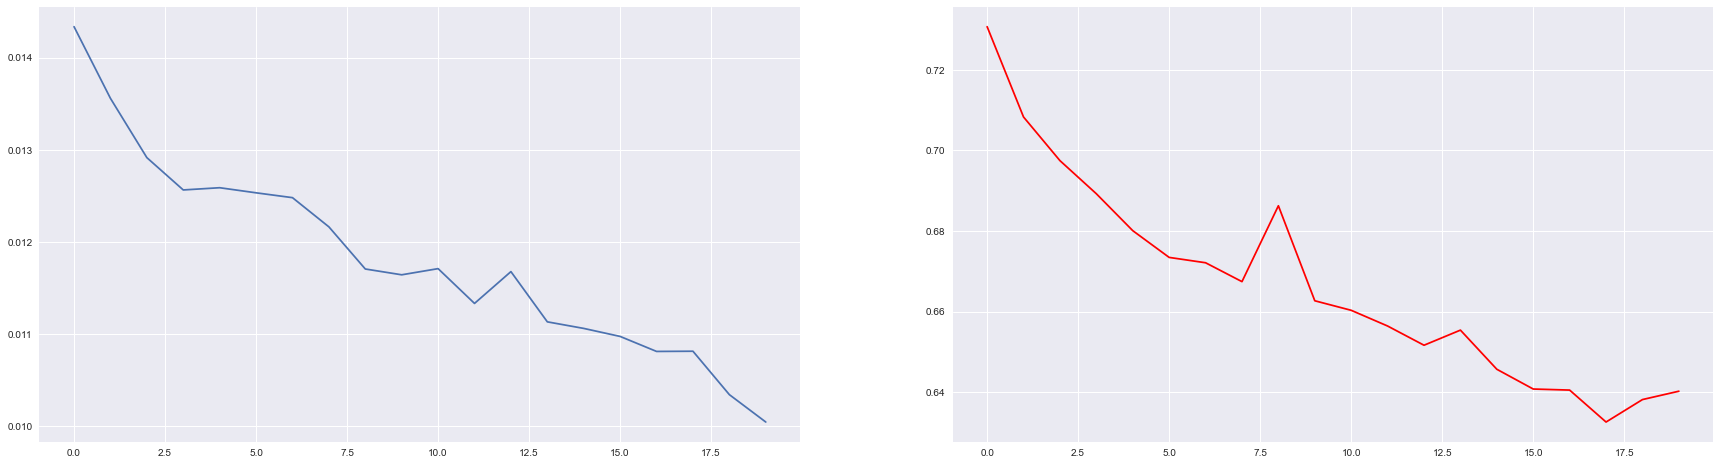

In [77]:
fig, axs = plt.subplots(1,2,figsize=(30,8))
axs[0].plot(np.arange(NUM_EPOCHS), losses)
axs[1].plot(np.arange(NUM_EPOCHS), val_losses, color='red')
plt.show()

### Оценка точности

In [78]:
recon = net(X_val_tensor)
a = np.reshape(recon.detach().numpy(),(-1, CUT_LEN, 31))
b = np.reshape(X_val_tensor.detach().numpy(),(-1, CUT_LEN, 31))

r = np.random.randint(0, len(a))
a[r, :5, :5], b[r, :5, :5], r

(array([[-0.04433817,  0.32921386,  0.04245998,  0.0489903 ,  0.04551768],
        [-0.0882789 ,  0.34142464,  0.11062782, -0.02295165,  0.03380968],
        [ 0.10424642,  0.31819245,  0.11505859,  0.07145011,  0.04586897],
        [ 0.01393688,  0.28669602,  0.06810117,  0.06640361,  0.07022341],
        [ 0.03296708,  0.2750246 ,  0.07107889,  0.08062786,  0.14050134]],
       dtype=float32),
 array([[ 0.01884696,  0.3062946 , -0.07130671,  0.0304493 ,  0.02086332],
        [ 0.01884696,  0.3062946 , -0.06427883,  0.01934285,  0.04398231],
        [ 0.01884696,  0.3062946 , -0.11885598, -0.01066441, -0.09172933],
        [ 0.01884696,  0.3062946 , -0.06963634,  0.00473973,  0.01612647],
        [ 0.01884696,  0.3062946 , -0.07160059,  0.03101881, -0.07264537]],
       dtype=float32),
 155)

In [71]:
# with torch.no_grad():
#     y_pred = torch.softmax(net(X_val_tensor), 1)
#     y = torch.argmax(y_pred, axis=1)
# #     print(net(X_val_tensor).shape)
#     print(roc_auc_score(y_val_tensor, y_pred, multi_class='ovo'))
#     print(f1_score(y_val_tensor, y, average='macro'))